In [3]:
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn

In [6]:
a = mx.sym.Variable('a')
b = mx.sym.Variable('b')
c = mx.sym.Variable('c')

# 定义计算关系
d = (a + b) * c

# 基本操作
## 指定每个输入符号对应的输出

In [4]:
input_args = {
    'a' : nd.array([1]),
    'b' : nd.array([2]),
    'c' : nd.array([3])
}

`a`, `b`, `c`, d` 定义的只是计算关系，执行计算（包括申请内存等操作）需要 Executor 用 `bind()` 函数指定输入，`d` 为输出。

In [7]:
executor = d.bind(ctx=mx.cpu(), args=input_args)

## 执行计算

In [9]:
executor.forward()

[
 [ 9.]
 <NDArray 1 @cpu(0)>]

In [11]:
executor.outputs[0].asnumpy()

array([ 9.], dtype=float32)

符号式计算是函数式编程的思路，计算是延迟的（Lazy），符号变量只是用来把数据的 NDArray 和 Symbol 绑定起来，实际的计算发生在 Executor 调用时。

### 初始化一个变量用来保存关于 $a$ 的梯度

In [15]:
grad_a = mx.nd.empty(1)

### 在 `bind()` 函数中指定要求梯度的变量

In [18]:
executor = d.bind(
    ctx=mx.cpu(0),
    args = input_args,
    args_grad = {'a' : grad_a}
)

因为梯度是传播的，所以最后的输出节点的梯度需要指定，这里用$1$：

In [19]:
executor.backward(out_grads=mx.nd.ones(1))

In [20]:
# 计算出梯度，将自动刷新在 grad_a 中
grad_a


[ 3.]
<NDArray 1 @cpu(0)>

`mx.kvstore` 模块支持分布式计算。

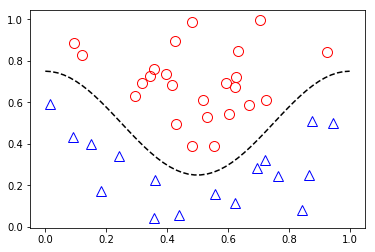

In [22]:
import pickle
import numpy as np
import matplotlib.pyplot as plt


def cos_curve(x):
    return 0.25*np.sin(2*x*np.pi+0.5*np.pi) + 0.5


np.random.seed(123)
samples = []
labels = []

sample_density = 50
for i in range(sample_density):
    x1, x2 = np.random.random(2)
    bound = cos_curve(x1)
    if bound - 0.1 < x2 <= bound + 0.1:
        continue
    else:
        samples.append((x1, x2))
        if x2 > bound:
            labels.append(1)
        else:
            labels.append(0)

with open('data.pkl', 'wb') as f:
    pickle.dump((samples, labels), f)

for i, sample in enumerate(samples):
    plt.plot(sample[0], sample[1],
             'o' if labels[i] else '^',
             mec='r' if labels[i] else 'b',
             mfc='none',
             markersize=10)

x1 = np.linspace(0, 1)
plt.plot(x1, cos_curve(x1), 'k--')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\mxnet\model.py:986: DeprecationWarning: mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.
  optimizer=optimizer, initializer=initializer, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\mxnet\model.py:573: DeprecationWarning: Calling initializer with init(str, NDArray) has been deprecated.please use init(mx.init.InitDesc(...), NDArray) instead.
  self.initializer(k, v)
INFO:root:Start training with [cpu(0)]
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=0.013
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=0.005
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Epoch[2] Time cost=0.010
INFO:root:Epoch[3] Resetting Data Iterator
INFO:root:Epoch[3] Time cost=0.005
INFO:root:Epoch[4] Resetting Data Iterator
INFO:root:Epoch[4] Time cost=0.008
INFO:root:Epoch[5] Resetting Data Iterator
INFO:root:Epoch[5] Time cost=0.008
INFO:root:Epoch[6] Resetting Data Iterato

INFO:root:Epoch[96] Time cost=0.003
INFO:root:Epoch[97] Resetting Data Iterator
INFO:root:Epoch[97] Time cost=0.004
INFO:root:Epoch[98] Resetting Data Iterator
INFO:root:Epoch[98] Time cost=0.011
INFO:root:Epoch[99] Resetting Data Iterator
INFO:root:Epoch[99] Time cost=0.005
INFO:root:Epoch[100] Resetting Data Iterator
INFO:root:Epoch[100] Time cost=0.005
INFO:root:Epoch[101] Resetting Data Iterator
INFO:root:Epoch[101] Time cost=0.003
INFO:root:Epoch[102] Resetting Data Iterator
INFO:root:Epoch[102] Time cost=0.005
INFO:root:Epoch[103] Resetting Data Iterator
INFO:root:Epoch[103] Time cost=0.010
INFO:root:Epoch[104] Resetting Data Iterator
INFO:root:Epoch[104] Time cost=0.009
INFO:root:Epoch[105] Resetting Data Iterator
INFO:root:Epoch[105] Time cost=0.005
INFO:root:Epoch[106] Resetting Data Iterator
INFO:root:Epoch[106] Time cost=0.011
INFO:root:Epoch[107] Resetting Data Iterator
INFO:root:Epoch[107] Time cost=0.013
INFO:root:Epoch[108] Resetting Data Iterator
INFO:root:Epoch[108] Ti

INFO:root:Epoch[196] Time cost=0.004
INFO:root:Epoch[197] Resetting Data Iterator
INFO:root:Epoch[197] Time cost=0.004
INFO:root:Epoch[198] Resetting Data Iterator
INFO:root:Epoch[198] Time cost=0.005
INFO:root:Epoch[199] Resetting Data Iterator
INFO:root:Epoch[199] Time cost=0.004
INFO:root:Epoch[200] Resetting Data Iterator
INFO:root:Epoch[200] Time cost=0.004
INFO:root:Epoch[201] Resetting Data Iterator
INFO:root:Epoch[201] Time cost=0.005
INFO:root:Epoch[202] Resetting Data Iterator
INFO:root:Epoch[202] Time cost=0.003
INFO:root:Epoch[203] Resetting Data Iterator
INFO:root:Epoch[203] Time cost=0.003
INFO:root:Epoch[204] Resetting Data Iterator
INFO:root:Epoch[204] Time cost=0.004
INFO:root:Epoch[205] Resetting Data Iterator
INFO:root:Epoch[205] Time cost=0.003
INFO:root:Epoch[206] Resetting Data Iterator
INFO:root:Epoch[206] Time cost=0.003
INFO:root:Epoch[207] Resetting Data Iterator
INFO:root:Epoch[207] Time cost=0.004
INFO:root:Epoch[208] Resetting Data Iterator
INFO:root:Epoch[

INFO:root:Epoch[296] Time cost=0.005
INFO:root:Epoch[297] Resetting Data Iterator
INFO:root:Epoch[297] Time cost=0.004
INFO:root:Epoch[298] Resetting Data Iterator
INFO:root:Epoch[298] Time cost=0.004
INFO:root:Epoch[299] Resetting Data Iterator
INFO:root:Epoch[299] Time cost=0.004
INFO:root:Epoch[300] Resetting Data Iterator
INFO:root:Epoch[300] Time cost=0.004
INFO:root:Epoch[301] Resetting Data Iterator
INFO:root:Epoch[301] Time cost=0.004
INFO:root:Epoch[302] Resetting Data Iterator
INFO:root:Epoch[302] Time cost=0.004
INFO:root:Epoch[303] Resetting Data Iterator
INFO:root:Epoch[303] Time cost=0.004
INFO:root:Epoch[304] Resetting Data Iterator
INFO:root:Epoch[304] Time cost=0.004
INFO:root:Epoch[305] Resetting Data Iterator
INFO:root:Epoch[305] Time cost=0.005
INFO:root:Epoch[306] Resetting Data Iterator
INFO:root:Epoch[306] Time cost=0.003
INFO:root:Epoch[307] Resetting Data Iterator
INFO:root:Epoch[307] Time cost=0.003
INFO:root:Epoch[308] Resetting Data Iterator
INFO:root:Epoch[

INFO:root:Epoch[396] Time cost=0.006
INFO:root:Epoch[397] Resetting Data Iterator
INFO:root:Epoch[397] Time cost=0.003
INFO:root:Epoch[398] Resetting Data Iterator
INFO:root:Epoch[398] Time cost=0.004
INFO:root:Epoch[399] Resetting Data Iterator
INFO:root:Epoch[399] Time cost=0.003
INFO:root:Epoch[400] Resetting Data Iterator
INFO:root:Epoch[400] Time cost=0.006
INFO:root:Epoch[401] Resetting Data Iterator
INFO:root:Epoch[401] Time cost=0.004
INFO:root:Epoch[402] Resetting Data Iterator
INFO:root:Epoch[402] Time cost=0.008
INFO:root:Epoch[403] Resetting Data Iterator
INFO:root:Epoch[403] Time cost=0.003
INFO:root:Epoch[404] Resetting Data Iterator
INFO:root:Epoch[404] Time cost=0.005
INFO:root:Epoch[405] Resetting Data Iterator
INFO:root:Epoch[405] Time cost=0.003
INFO:root:Epoch[406] Resetting Data Iterator
INFO:root:Epoch[406] Time cost=0.004
INFO:root:Epoch[407] Resetting Data Iterator
INFO:root:Epoch[407] Time cost=0.003
INFO:root:Epoch[408] Resetting Data Iterator
INFO:root:Epoch[

INFO:root:Epoch[496] Time cost=0.004
INFO:root:Epoch[497] Resetting Data Iterator
INFO:root:Epoch[497] Time cost=0.005
INFO:root:Epoch[498] Resetting Data Iterator
INFO:root:Epoch[498] Time cost=0.004
INFO:root:Epoch[499] Resetting Data Iterator
INFO:root:Epoch[499] Time cost=0.004
INFO:root:Epoch[500] Resetting Data Iterator
INFO:root:Epoch[500] Time cost=0.005
INFO:root:Epoch[501] Resetting Data Iterator
INFO:root:Epoch[501] Time cost=0.004
INFO:root:Epoch[502] Resetting Data Iterator
INFO:root:Epoch[502] Time cost=0.004
INFO:root:Epoch[503] Resetting Data Iterator
INFO:root:Epoch[503] Time cost=0.004
INFO:root:Epoch[504] Resetting Data Iterator
INFO:root:Epoch[504] Time cost=0.003
INFO:root:Epoch[505] Resetting Data Iterator
INFO:root:Epoch[505] Time cost=0.004
INFO:root:Epoch[506] Resetting Data Iterator
INFO:root:Epoch[506] Time cost=0.004
INFO:root:Epoch[507] Resetting Data Iterator
INFO:root:Epoch[507] Time cost=0.005
INFO:root:Epoch[508] Resetting Data Iterator
INFO:root:Epoch[

INFO:root:Epoch[596] Time cost=0.003
INFO:root:Epoch[597] Resetting Data Iterator
INFO:root:Epoch[597] Time cost=0.003
INFO:root:Epoch[598] Resetting Data Iterator
INFO:root:Epoch[598] Time cost=0.003
INFO:root:Epoch[599] Resetting Data Iterator
INFO:root:Epoch[599] Time cost=0.003
INFO:root:Epoch[600] Resetting Data Iterator
INFO:root:Epoch[600] Time cost=0.003
INFO:root:Epoch[601] Resetting Data Iterator
INFO:root:Epoch[601] Time cost=0.003
INFO:root:Epoch[602] Resetting Data Iterator
INFO:root:Epoch[602] Time cost=0.003
INFO:root:Epoch[603] Resetting Data Iterator
INFO:root:Epoch[603] Time cost=0.003
INFO:root:Epoch[604] Resetting Data Iterator
INFO:root:Epoch[604] Time cost=0.004
INFO:root:Epoch[605] Resetting Data Iterator
INFO:root:Epoch[605] Time cost=0.003
INFO:root:Epoch[606] Resetting Data Iterator
INFO:root:Epoch[606] Time cost=0.004
INFO:root:Epoch[607] Resetting Data Iterator
INFO:root:Epoch[607] Time cost=0.004
INFO:root:Epoch[608] Resetting Data Iterator
INFO:root:Epoch[

INFO:root:Epoch[696] Time cost=0.004
INFO:root:Epoch[697] Resetting Data Iterator
INFO:root:Epoch[697] Time cost=0.005
INFO:root:Epoch[698] Resetting Data Iterator
INFO:root:Epoch[698] Time cost=0.005
INFO:root:Epoch[699] Resetting Data Iterator
INFO:root:Epoch[699] Time cost=0.013
INFO:root:Epoch[700] Resetting Data Iterator
INFO:root:Epoch[700] Time cost=0.006
INFO:root:Epoch[701] Resetting Data Iterator
INFO:root:Epoch[701] Time cost=0.004
INFO:root:Epoch[702] Resetting Data Iterator
INFO:root:Epoch[702] Time cost=0.006
INFO:root:Epoch[703] Resetting Data Iterator
INFO:root:Epoch[703] Time cost=0.004
INFO:root:Epoch[704] Resetting Data Iterator
INFO:root:Epoch[704] Time cost=0.004
INFO:root:Epoch[705] Resetting Data Iterator
INFO:root:Epoch[705] Time cost=0.003
INFO:root:Epoch[706] Resetting Data Iterator
INFO:root:Epoch[706] Time cost=0.004
INFO:root:Epoch[707] Resetting Data Iterator
INFO:root:Epoch[707] Time cost=0.003
INFO:root:Epoch[708] Resetting Data Iterator
INFO:root:Epoch[

INFO:root:Epoch[796] Time cost=0.003
INFO:root:Epoch[797] Resetting Data Iterator
INFO:root:Epoch[797] Time cost=0.003
INFO:root:Epoch[798] Resetting Data Iterator
INFO:root:Epoch[798] Time cost=0.003
INFO:root:Epoch[799] Resetting Data Iterator
INFO:root:Epoch[799] Time cost=0.003
INFO:root:Epoch[800] Resetting Data Iterator
INFO:root:Epoch[800] Time cost=0.002
INFO:root:Epoch[801] Resetting Data Iterator
INFO:root:Epoch[801] Time cost=0.003
INFO:root:Epoch[802] Resetting Data Iterator
INFO:root:Epoch[802] Time cost=0.004
INFO:root:Epoch[803] Resetting Data Iterator
INFO:root:Epoch[803] Time cost=0.004
INFO:root:Epoch[804] Resetting Data Iterator
INFO:root:Epoch[804] Time cost=0.003
INFO:root:Epoch[805] Resetting Data Iterator
INFO:root:Epoch[805] Time cost=0.003
INFO:root:Epoch[806] Resetting Data Iterator
INFO:root:Epoch[806] Time cost=0.004
INFO:root:Epoch[807] Resetting Data Iterator
INFO:root:Epoch[807] Time cost=0.003
INFO:root:Epoch[808] Resetting Data Iterator
INFO:root:Epoch[

INFO:root:Epoch[896] Time cost=0.003
INFO:root:Epoch[897] Resetting Data Iterator
INFO:root:Epoch[897] Time cost=0.003
INFO:root:Epoch[898] Resetting Data Iterator
INFO:root:Epoch[898] Time cost=0.002
INFO:root:Epoch[899] Resetting Data Iterator
INFO:root:Epoch[899] Time cost=0.003
INFO:root:Epoch[900] Resetting Data Iterator
INFO:root:Epoch[900] Time cost=0.003
INFO:root:Epoch[901] Resetting Data Iterator
INFO:root:Epoch[901] Time cost=0.003
INFO:root:Epoch[902] Resetting Data Iterator
INFO:root:Epoch[902] Time cost=0.003
INFO:root:Epoch[903] Resetting Data Iterator
INFO:root:Epoch[903] Time cost=0.003
INFO:root:Epoch[904] Resetting Data Iterator
INFO:root:Epoch[904] Time cost=0.003
INFO:root:Epoch[905] Resetting Data Iterator
INFO:root:Epoch[905] Time cost=0.003
INFO:root:Epoch[906] Resetting Data Iterator
INFO:root:Epoch[906] Time cost=0.003
INFO:root:Epoch[907] Resetting Data Iterator
INFO:root:Epoch[907] Time cost=0.003
INFO:root:Epoch[908] Resetting Data Iterator
INFO:root:Epoch[

INFO:root:Epoch[996] Time cost=0.004
INFO:root:Epoch[997] Resetting Data Iterator
INFO:root:Epoch[997] Time cost=0.002
INFO:root:Epoch[998] Resetting Data Iterator
INFO:root:Epoch[998] Time cost=0.003
INFO:root:Epoch[999] Resetting Data Iterator
INFO:root:Epoch[999] Time cost=0.003


[[ 0.41300035  0.58699965]]


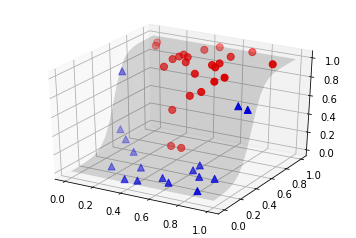

In [26]:
import pickle
import logging
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the network
data = mx.sym.Variable('data')
fc1 = mx.sym.FullyConnected(data=data, name='fc1', num_hidden=2)
sigmoid1 = mx.sym.Activation(data=fc1, name='sigmoid1', act_type='sigmoid')
fc2 = mx.sym.FullyConnected(data=sigmoid1, name='fc2', num_hidden=2)
mlp = mx.sym.SoftmaxOutput(data=fc2, name='softmax')

shape = {'data': (2, )}
mlp_dot = mx.viz.plot_network(symbol=mlp, shape=shape)
mlp_dot.render('simple_mlp.gv', view=True)

# Load data & train the model
with open('data.pkl', 'rb') as f:
    samples, labels = pickle.load(f)

logging.getLogger().setLevel(logging.DEBUG)

batch_size = len(labels)
samples = np.array(samples)
labels = np.array(labels)

train_iter = mx.io.NDArrayIter(samples, labels, batch_size)

model = mx.model.FeedForward.create(
    symbol=mlp, X=train_iter, num_epoch=1000, learning_rate=0.1, momentum=0.99)
'''
# Alternative interface to train the model
model = mx.model.FeedForward(
    symbol=mlp,
    num_epoch=1000,
    learning_rate=0.1,
    momentum=0.99)
model.fit(X=train_iter)
'''

print(model.predict(mx.nd.array([[0.5, 0.5]])))

# Visualize result
X = np.arange(0, 1.05, 0.05)
Y = np.arange(0, 1.05, 0.05)
X, Y = np.meshgrid(X, Y)

grids = mx.nd.array(
    [[X[i][j], Y[i][j]] for i in range(X.shape[0]) for j in range(X.shape[1])])
grid_probs = model.predict(grids)[:, 1].reshape(X.shape)

fig = plt.figure('Sample Surface')
ax = fig.gca(projection='3d')

ax.plot_surface(
    X, Y, grid_probs, alpha=0.15, color='k', rstride=2, cstride=2, lw=0.5)
samples0 = samples[labels == 0]
samples0_probs = model.predict(samples0)[:, 1]
samples1 = samples[labels == 1]
samples1_probs = model.predict(samples1)[:, 1]

ax.scatter(
    samples0[:, 0], samples0[:, 1], samples0_probs, c='b', marker='^', s=50)
ax.scatter(
    samples1[:, 0], samples1[:, 1], samples1_probs, c='r', marker='o', s=50)

plt.show()

In [33]:
net = nn.HybridSequential()
with net.name_scope():
    net.add(
        nn.Conv2D(channels=20, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=50, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(128, activation="relu"),
        nn.Dense(10)
    )

In [39]:
net.initialize()
net.hybridize()
net

HybridSequential(
  (0): Conv2D(None -> 20, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (2): Conv2D(None -> 50, kernel_size=(3, 3), stride=(1, 1))
  (3): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (4): Flatten
  (5): Dense(None -> 128, Activation(relu))
  (6): Dense(None -> 10, linear)
)

In [45]:
x = nd.random.normal(shape=(100, 32, 32, 3))

In [46]:
net(x)

infer_shape error. Arguments:
  data: (100, 32, 32, 3)


MXNetError: Error in operator hybridsequential0_conv0_fwd: [15:51:02] D:\Program Files (x86)\Jenkins\workspace\mxnet\mxnet\src\operator\nn\convolution.cc:194: Check failed: dilated_ksize_x <= AddPad(dshape[3], param_.pad[1]) (5 vs. 3) kernel size exceed input

In [47]:
mx.viz.plot_network(symbol=net, shape={'x':(200, 32, 32, 3)})

TypeError: symbol must be a Symbol